# Estrazione Growth factor da CLASS

In [249]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate

# Primo tentativo: dal notebook

In [250]:
w0vec = [-0.7, -1.0, -1.3]
wavec = [-0.2,0.0,0.2]
#w0vec = [-1.0]
#wavec = [0.0]
 
cosmo = {}
for w0 in w0vec:
    for wa in wavec:
        if w0==-1.0 and wa==0.0:
            M='LCDM'
        else:
            M = '('+str(w0)+','+str(wa)+')'
        cosmo[M] = Class()
        cosmo[M].set({'input_verbose':1,'background_verbose':1,'gauge' : 'Newtonian'})
        if M!='LCDM':
            cosmo[M].set({'Omega_Lambda':0.,'w0_fld':w0,'wa_fld':wa})
        cosmo[M].compute()

Reading input parameters
 -> matched budget equations by adjusting Omega_fld = 0.690026
Running CLASS version v3.2.1
Computing background
 -> age = 13.176241 Gyr
 -> conformal age = 13799.209339 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3405.751108
    corresponding to conformal time = 112.722902 Mpc
Reading input parameters
 -> matched budget equations by adjusting Omega_fld = 0.690026
Running CLASS version v3.2.1
Computing background
 -> age = 13.028458 Gyr
 -> conformal age = 13674.751158 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3405.751108
    corresponding to conformal time = 112.722901 Mpc
Reading input parameters
 -> matched budget equations by adjusting Omega_fld = 0.690026
Running CLASS version v3.2.1
Computing background
 -> age = 12.853929 Gyr
 -> conformal age = 13507.284863 Mpc
 -> N_eff = 3.044 (summed o

In [251]:
import scipy
import scipy.special
import scipy.integrate

def D_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if '(.)rho_lambda' in bg:
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    D_today = scipy.special.hyp2f1(1./3.,1,11./6.,-Ol/Om)
    return D/D_today

In [252]:

bg = cosmo['LCDM'].get_background()

z = bg['z']
a = 1./(z+1)

D_app = bg['gr.fac. D']     #D approssimato
D_ana = D_hypergeom(a,cosmo['LCDM'])    #D analitico


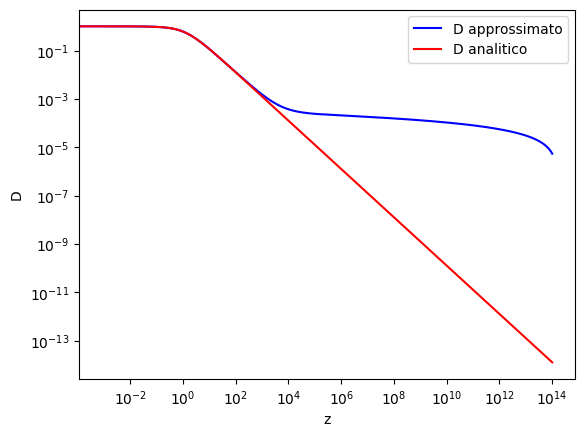

In [253]:
plt.loglog(z, D_app, color='blue', label='D approssimato')
plt.loglog(z, D_ana, color='red', label='D analitico')

plt.xlabel('z')
plt.ylabel('D')

plt.legend()
plt.draw()

# Secondo tentativo

In [254]:
from classy import Class

In [255]:
M = Class()
cosmo = {'omega_b': 0.02238280, 'omega_cdm': 0.1201075, 'h': 0.67810, 'ln10^{10}A_s': 3.04478383, 'n_s': 0.9660499}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': 1})
M.compute()

In [256]:
bg = M.get_background()

z = bg['z']
a = 1./(z+1)

D_num = bg['gr.fac. D']     #D numerico
D_ana = D_hypergeom(a,M)    #D analitico

print(z[0])
print(z[37023])
print(z[-1])

99999999999999.12
10.005912117879722
0.0


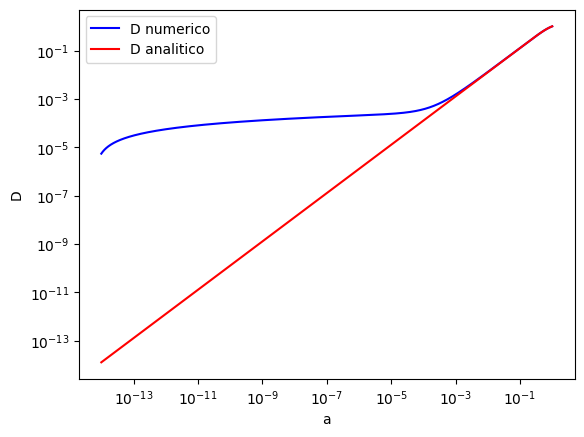

In [257]:
plt.loglog(a, D_num, color='blue', label='D numerico')
plt.loglog(a, D_ana, color='red', label='D analitico')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.draw()

# Terzo tentativo: growth rate

$$ f = \dfrac{d \ln D(a)}{d \ln a} $$

In [258]:
f_ind = []
f_dep = []
R = np.empty(0)

# fisso la scala
k = 0.001

# considero il redshift (r) tra 0 e 2, altriemnti non calcola D dipendente dalla scala
for i in range(2000, 0, -1) :
    r = i/1000.
    R = np.append(R,r)
    f_ind.append(M.scale_independent_growth_factor_f(r))
    f_dep.append(M.scale_dependent_growth_factor_f(k, r))

A = 1./(R+1)


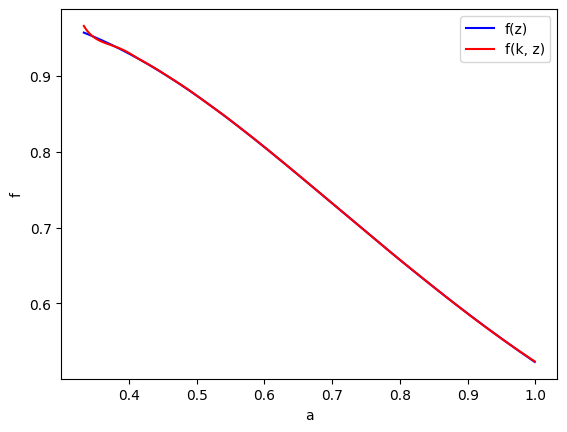

In [259]:
plt.plot(A, f_ind, color='blue', label='f(z)')
plt.plot(A, f_dep, color='red', label='f(k, z)')

plt.xlabel('a')
plt.ylabel('f')

plt.legend()
plt.show()

**Paragono i growth factors del secondo e del terzo tentativo**

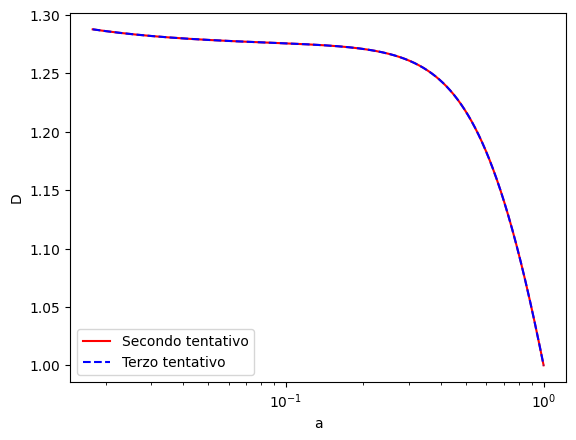

In [260]:
# oltre a confrontare i due precdenti risultati ho provato a riottenere la figura 8.15 del Dodelson, pag 221, ma il risultato non è corretto
D2 = D_num
D3 = []

z = bg['z']
a = 1./(z+1)

for r in z :
    D3.append(M.scale_independent_growth_factor(r))
s = 5000
plt.semilogx(a[-s:], D2[-s:]/a[-s:], color='red', label='Secondo tentativo')
plt.semilogx(a[-s:], D3[-s:]/a[-s:], ls='--', color='blue', label='Terzo tentativo')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.show()

# Quarto tentativo: rapporto dei Power spectra

$$ P(k,z) = \mathcal{P}(k) T^2(k)D^2(k,z) $$
$$ \sqrt{\dfrac{P(k,z)}{P(k,0)}} = \dfrac{D(k,z)}{D(k,0)} $$

In [261]:
# creao una cosmologia
LambdaCDM = Class()
# setto i parametri del modello
LambdaCDM.set({
    'omega_b': 0.02238280, 
    'omega_cdm': 0.1201075, 
    'h': 0.67810, 
    'A_s': 2.100549e-09, 
    'n_s':0.9660499, 
    'tau_reio':0.05430842, 
    'z_max_pk':10
    })
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk',
               'lensing':'yes',
               'P_k_max_1/Mpc':3.0
               })
# eseguo CLASS
LambdaCDM.compute()

In [262]:
# definisco il range di scale k = [10^-4; 3] e di redshift z = [0; 10]
n = 2977
kk = np.logspace(-4, np.log10(3), n)    # k in h/Mpc
zz = np.arange(10, 0, -10/n)            # 2977 punti di reshift
aa = 1./(zz+1)                          # converto il redshift in fattore di scala

Pkz = [[0 for i in range(n)] for i in range(n)]
h = LambdaCDM.h()       # get reduced Hubble for conversions to 1/Mpc

# calcolo il Power spectrum per tutti i valori di k e a
for k in range(n) :
    for a in range(n) :
        Pkz[k][a] = LambdaCDM.pk(kk[k]*h, aa[a])*h**3


In [263]:
# estraggo il growth factor normalizato dal rapporto Pkz(k,z)/Pkz(k,0)
d = [[0 for i in range(n)] for i in range(n)]

for k in range(n) :
    for a in range(n) :
        d[k][a] = np.sqrt(Pkz[k][a]/Pkz[k][-1])

Dkz = np.array(d)

z = bg['z'][37023:]
a = 1./(z+1)
Dz = bg['gr.fac. D'][37023:]


np.save('D(k,z)', Dkz)
np.save('D(z)', Dz)
#np.savetxt('growth', Dkz)


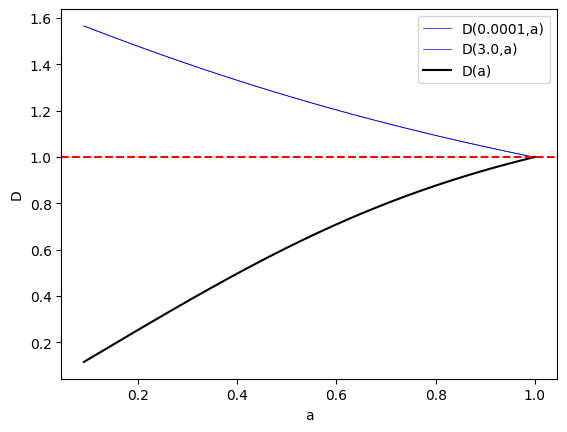

In [264]:
# plotto D(k,a) con variabile a e parametro k, plotto anche D(a)

plt.plot(aa, Dkz[0,:], color='blue', label='D(' + str(kk[0]) + ',a)', linewidth='0.5')
plt.plot(aa, Dkz[2976,:], color='blue', label='D(' + str(kk[2976]) + ',a)', linewidth='0.5')
plt.plot(a, Dz, color='black', label='D(a)')
plt.axhline(y=1, color='red', linestyle='--')

plt.xlabel('a')
plt.ylabel('D')

plt.legend()
plt.show()

In [268]:
print(Dz[2976])
print(Dkz[2976,0])

N= len(z)
print(N)

1.0
1.5644248678765162
2977
